In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
import subprocess

BASE_DIRECTORY = '/Users/emarberg/examples/test/'

def draw_graph(vertices, edges, neato=True):
    def prt(w):
        return ''.join(map(str, w[:-1])) + ':' + str(w[-1])
    s = ['digraph G {']
    s += ['    overlap=false;']
    s += ['    splines=true;']
    s += ['    node [shape=box];']
    for x in vertices:
       s += ['    "%s" [fillcolor=white];' % prt(x)]
    for x, y, label in edges:
        if x in vertices and y in vertices:
            s += ['    "%s" -> "%s" [color="%s"];' % (prt(x), prt(y), 'red' if label else 'black')]
    s += ['}']
    s = '\n'.join(s)
    #
    filename = 'tmp' + str(len(vertices))
    dot_filename = BASE_DIRECTORY + 'dot/' + '%s.dot' % filename
    png_filename = BASE_DIRECTORY + 'png/' + '%s.png' % filename
    with open(dot_filename, 'w') as f:
        f.write(s)
    subprocess.run(["neato" if neato else "dot", "-Tpng", dot_filename, "-o", png_filename])
    subprocess.run(["open", png_filename])

In [207]:
def is_connected(v, e):
    if len(v) == 0:
        return True
    component = {next(iter(v))}
    size = len(component)
    while True:
        component |= {b for (a, b, i) in e if a in component} | {a for (a, b, i) in e if b in component}
        if len(component) == size:
            break
        size = len(component)
    return len(component) == len(v)

In [218]:
def digraph_sources(v, e):
    ans = set(v)
    for a, b, i in e:
        if b in ans:
            ans.remove(b)
    return ans


def digraph_sinks(v, e):
    ans = set(v)
    for a, b, i in e:
        if a in ans:
            ans.remove(a)
    return ans

In [198]:
from permutations import Permutation, Partition
from tests.test_ogroth import read_cplusplus_ogroth

def read(*mu):
    n = max(mu, default=0) + 2
    ans = read_cplusplus_ogroth(mu)
    bns = {}
    for w, c in ans:
        w = tuple(Permutation(*w).inverse().oneline)
        while len(w) < n:
            w += (len(w) + 1,)
        bns[w] = c
    return bns

In [389]:
def undirected_chinese_span(w, n=None):
    if n is not None and w[-1] != n + 1:
        return
    for i in range(len(w) - 2):
        c, b, a = w[i: i + 3]
        if a < b < c:
            yield (w[:i] + (b, c, a) + w[i + 3:], w, False)
            yield (w[:i] + (c, a, b) + w[i + 3:], w, False)
        b, c, a = w[i: i + 3]
        if a < b < c:
            yield (w[:i] + (c, b, a) + w[i + 3:], w, False)
            yield (w[:i] + (c, a, b) + w[i + 3:], w, False)
        c, a, b = w[i: i + 3]
        if a < b < c:
            yield (w[:i] + (c, b, a) + w[i + 3:], w, False)
            yield (w[:i] + (b, c, a) + w[i + 3:], w, False)


def undirected_chinese_class(w):
    ans = set()
    add = {w}
    while add:
        ans |= add
        add = {v for (w, v) in undirected_chinese_span(w) if v not in ans}
    return ans


def chinese_span(w, n):
    if w[-1] == n + 1:
        for i in range(len(w) - 2):
            c, b, a = w[i: i + 3]
            if a < b < c and c != n + 1:
                yield (w[:i] + (b, c, a) + w[i + 3:], w, False)
                yield (w[:i] + (c, a, b) + w[i + 3:], w, False)
            # b, c, a = w[i: i + 3]
            # if a < b < c and c != n + 1:
            #    yield (w[:i] + (c, a, b) + w[i + 3:], w, False)
            

def chinese_class(w):
    ans = set()
    add = {w}
    while add:
        ans |= add
        add = {v for (w, v) in chinese_span(w, -1) if v not in ans}
    return ans

In [200]:
def tr(x, a):
    return x + (a[x],) #
    # return Permutation(*x).code() + (a[x],)

def appl(t, a):
    x, y, i = t
    return (tr(x, a), tr(y, a), x[i] == len(x) or x[i+1] == len(x))

In [488]:
def ranked_graph(mu, draw=True):
    w =  Permutation.from_involution_shape(*mu)
    n = w.rank
    u = read(*mu)
    u = {x + (() if len(x) == n + 1 else (n + 1,)): u[x] for x in u}
    e = {
        (x, y, i)
        for x in u for y in u for i in range(len(x) - 1)
        if x < y and x[:i] + (x[i+1],x[i]) + x[i+2:] == y
    }
    if draw:
        print(w.cycle_repr())
        draw_graph({tr(x, u) for x in u}, {appl(t, u) for t in e}, neato=False)
    return (u, e)

def relation_graph(mu, draw=True):
    w =  Permutation.from_involution_shape(*mu)
    # h = {x.inverse() for x in w.get_involution_hecke_atoms()}
    n = w.rank
    u = read(*mu)
    u = {x + (() if len(x) == n + 1 else (n + 1,)): u[x] for x in u}
    e = {
        p
        # for x in u for p in undirected_chinese_span(x)
        # if Permutation(*p[0]) in h
        for x in u for p in chinese_span(x, n)
    } | {
        (x, y, True) 
        for x in u for y in u 
        if x < y and x[-1] == n + 1 and tuple(_ for _ in x if _ != n + 1) == tuple(_ for _ in y if _ != n + 1)
    }
    if draw:
        print(w.cycle_repr())
        draw_graph({tr(x, u) for x in u}, {(tr(a, u), tr(b, u), c) for (a, b, c) in e}, neato=False)
    return (u, e)

In [539]:
def print_edges(v, e):
    def represent(x, y):
        a = [str(x[i]) if x[i] != y[i] else '-' for i in range(len(x))]
        b = [str(y[i]) if x[i] != y[i] else '-' for i in range(len(x))]
        return ''.join(a), ''.join(b)
    
    for x, y, i in e:
        a, b = represent(x, y)
        print('  ', a)
        print('  ', b)
        print()

def test_edges(n, graph=ranked_graph):
    delta = tuple(range(n - 1, 0, -2))
    mus = sorted(Partition.subpartitions(delta, strict=True), key=sum)
    for i, mu in enumerate(mus):
        w = Permutation.from_involution_shape(*mu)
        n = w.rank + 1

        left = [a for a in range(1, n) if a < w(a)]
        right = [a for a in range(1, n) if a > w(a)]
        
        v, e = graph(mu, False)
        b = all(x[i + 1] in right or x[i] in left for (x, y, i) in e)
        c = all(
            (x, x[:i] + (x[i+1], x[i]) + x[i+2:], i) in e
            for x in v
            for i in range(len(x) - 1)
            if x[i] < x[i + 1] and (x[i] in left or x[i+1] in right)
        )
        if c:
            print('[', i + 1, 'of', len(mus), ']', mu, ':', w, ':', b, c)
        assert b
        

In [526]:
def test_connectedness(n, graph=ranked_graph):
    delta = tuple(range(n - 1, 0, -2))
    mus = sorted(Partition.subpartitions(delta, strict=True), key=sum)
    for i, mu in enumerate(mus):
        v, e = graph(mu, False)
        b = is_connected(v, e)
        c = len(digraph_sources(v, e)) == 1
        d = len(digraph_sinks(v, e)) == 1
        if b:
            print('[', i + 1, 'of', len(mus), ']', mu, ':', b, c, d)
        #print()
        #print('  ', Permutation.from_involution_shape(*mu).cycle_repr())
        #print('  ', digraph_sinks(v, e))
        #print()
        #assert b

In [494]:
def pad(x, n):
    return tuple(x.inverse().oneline) + tuple(range(x.rank + 1, n + 2))
    
def test_chinese_class(n):
    delta = tuple(range(n - 1, 0, -2))
    mus = sorted(Partition.subpartitions(delta, strict=True), key=sum)
    for i, mu in enumerate(mus):
        w = Permutation.from_involution_shape(*mu)
        n = max(1, w.rank)
        u = read(*mu)
        v = {x + (() if len(x) == n + 1 else (n + 1,)): u[x] for x in u}
        b = all(x in v for y in v for (x, y, _) in chinese_span(y, n))
        c1 = all(pad(x, n) in v for x in w.get_involution_hecke_atoms())
        c2 = {x.inverse() for x in w.get_involution_hecke_atoms()} == {Permutation(*x) for x in v if Permutation(*x).rank <= n}
        d1 = all(x in v for y in v for (x, y, _) in undirected_chinese_span(y, n))
        d2 = all(x in v for y in v for (x, y, _) in undirected_chinese_span(y))
        if c2:
            print('[', i + 1, 'of', len(mus), ']', mu)
            print()
            print('  directed ch relations:', b)
            print()
            print('  contains  invol hecke:', c1)
            print('  intersect invol hecke:', c2)
            print()
            print('  constr ch relations  :', d1)
            print('  all    ch relations  :', d2)
            print()
        assert b and c1

In [461]:
n = 6 
delta = tuple(range(n - 1, 0, -2))
mus = iter(sorted(Partition.subpartitions(delta, strict=True), key=sum))

In [542]:
mu = (3,)
print('mu =', mu)
print(' w =', Permutation.from_involution_shape(*mu).cycle_repr())
graph = ranked_graph
v, e = graph(mu, True)
print()
print('edges:')
# print_edges(v, e)

mu = (3,)
 w = (1, 4)
(1, 4)

edges:


In [541]:
test_edges(8, ranked_graph)

[ 1 of 70 ] () : () : True True
[ 2 of 70 ] (1,) : 21 : True True
[ 3 of 70 ] (2,) : 321 : True True
[ 7 of 70 ] (3, 1) : 4321 : True True
[ 13 of 70 ] (4, 2) : 54321 : True True
[ 29 of 70 ] (5, 3, 1) : 654321 : True True
[ 49 of 70 ] (6, 4, 2) : 7654321 : True True


KeyboardInterrupt: 

In [515]:
test_connectedness(8, relation_graph)

[ 1 of 70 ] () : True True True
[ 2 of 70 ] (1,) : True True True
[ 3 of 70 ] (2,) : True False False
[ 7 of 70 ] (3, 1) : True False False
[ 13 of 70 ] (4, 2) : True False False
[ 29 of 70 ] (5, 3, 1) : True False False
[ 49 of 70 ] (6, 4, 2) : True False False
[ 70 of 70 ] (7, 5, 3, 1) : True False False


In [ ]:
test_chinese_class(7)

In [332]:
graph = ranked_graph

In [333]:
relation_graph((3,1));

(1, 4)(2, 3)


In [319]:
graph((4,3,2,1,));

(1, 5)(2, 6)(3, 7)(4, 8)


In [297]:
graph((4,2,));

(1, 5)(2, 4)


In [17]:
mu = (3,1)
u = read(*mu)
u = {x: u[x] for x in u}

In [12]:
set(u.values())

{1, 2, 3, 4, 6}

In [13]:
e = {
    (x, y, i)
    for x in u for y in u for i in range(len(x) - 1)
    if x < y and x[:i] + (x[i+1],x[i]) + x[i+2:] == y
}

In [14]:
m = (mu[0] + 1) // 2

for x, y, i in e:
    assert m < x[i + 1] <= mu[0] + 1 or x[i] <= m

for x in u:
    for i in range(len(x) - 1):
        if x[i] >= x[i + 1]:
            continue
        y = x[:i] + (x[i + 1],x[i]) + x[i+2:]
        if m < x[i + 1] <= mu[0] + 1 or x[i] <= m:
            assert (x, y, i) in e


In [15]:
draw_graph({tr(x, u) for x in u}, {appl(t, u) for t in e}, neato=False)

In [532]:
n=6; 
delta = tuple(range(n - 1, 0, -2))
a = read(*delta)
e = {_ for v in a for _ in chinese_span(v, n)}
assert all(v in a and w in a for v, w, _ in e)
e = {appl(t) for t in e}
draw_graph({tr(x) for x in a if a[x] != max(a.values())}, e, neato=False)

In [266]:
co[n] = set({b: a[b] for b in a if b[-1] == n + 1}.values())

In [253]:
for k in sorted(co):
    print(k, sorted(co[k]))

1 [1]
2 [2]
3 [2, 3]
4 [4, 6]
5 [4, 6, 9, 10]
6 [8, 12, 18, 20]
7 [8, 12, 18, 20, 27, 30, 33, 34, 35]
8 [16, 24, 36, 40, 54, 60, 66, 68, 70]
9 [16, 24, 36, 40, 54, 60, 66, 68, 70, 81, 90, 99, 100, 102, 105, 106, 112, 115, 116, 119, 120, 124, 125, 126]


In [227]:
# from partitions import Partition
# mus = sorted(Partition.subpartitions(delta, strict=True), key=sum)
# for mu in mus:
#    a = read(*mu)
#    print(mu)
#    print(a)
#    print()
#    test_chinese_class(a, n)

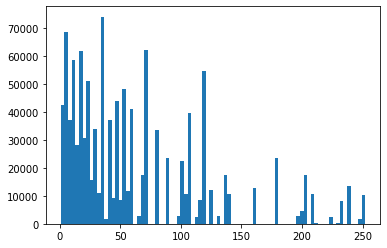

In [57]:
plt.hist(a.values(), len(set(a.values())));

Observations:
* contains Hecke atoms: all
* closed under directed Hecke relations: all
* ranked poset is connected: all 
* ranked poset has unique source: square
* ranked poset has unique sink: square, w0, some others
* (constrained Hecke & remove n+1) relation graph is connected: w0
* ranked edges only move left endpoints right, right endpoints left: all